In [104]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import sys
sys.path.append('C:/Users/Wazir')
import edhec_risk_kit as erk
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
brka_d =pd.read_csv('C:/Users/Wazir/Downloads/course 2 data/data/brka_d_ret.csv', parse_dates=True, index_col=0)

In [5]:
brka_d.head()

,BRKA
DATE,
1990-01-02,-0.005764
1990-01-03,0.000000
1990-01-04,0.005797
1990-01-05,-0.005764
1990-01-08,0.000000


In [11]:
#Converting the daily returns to monthly returns

brka_m =brka_d.resample('M').apply(erk.compound).to_period('M')
brka_m.head()

,BRKA
DATE,
1990-01,-0.140634
1990-02,-0.030852
1990-03,-0.069204
1990-04,-0.003717
1990-05,0.067164


In [19]:
def get_fff_returns():
    
    df = pd.read_csv('C:/Users/Wazir/Downloads/course 2 data/data/F-F_Research_Data_Factors_m.csv', parse_dates=True,
                 index_col=0, na_values=-99.99)/100
    df.index= pd.to_datetime(df.index, format='%Y%m').to_period('M')
    
    return df
    

In [20]:
fff = get_fff_returns()

In [21]:
fff.head()

,Mkt-RF,SMB,HML,RF
1926-07,0.0296,-0.0230,-0.0287,0.0022
1926-08,0.0264,-0.0140,0.0419,0.0025
1926-09,0.0036,-0.0132,0.0001,0.0023
1926-10,-0.0324,0.0004,0.0051,0.0032
1926-11,0.0253,-0.0020,-0.0035,0.0031


# $$ R_{brka,t} - R_{f,t} = \alpha + \beta(R_{mkt,t} - R_{f,t}) + \epsilon_t $$

In [45]:
import statsmodels.api as sm
brka_excess = brka_m['1990':'2015-05'] -fff.loc['1990':'2015-05', ['RF']].values
mkt_excess = fff.loc['1990':'2015-05', ['Mkt-RF']]

In [50]:
exp_var = mkt_excess.copy()
exp_var['Constant'] = 1
lm = sm.OLS(brka_excess, exp_var).fit()

In [51]:
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   BRKA   R-squared:                       0.163
Model:                            OLS   Adj. R-squared:                  0.160
Method:                 Least Squares   F-statistic:                     59.05
Date:                Fri, 03 Jul 2020   Prob (F-statistic):           2.15e-13
Time:                        16:00:05   Log-Likelihood:                 454.77
No. Observations:                 305   AIC:                            -905.5
Df Residuals:                     303   BIC:                            -898.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Mkt-RF         0.5554      0.072      7.685      0.000       0.413       0.698
Constant       0.0063      0.003      2.005      0.046       0.000       0.013
==============================================================================
Omnibus:                       54.924   Durbin-Watson:                   2.070
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              141.859
Skew:                           0.840   Prob(JB):                     1.57e-31
Kurtosis:                       5.888   Cond. No.                         23.1
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [61]:
exp_var["Value"] = fff.loc["1990":"2012-05",['HML']]
exp_var["Size"] = fff.loc["1990":"2012-05",['SMB']]
exp_var.isnull().sum()

Mkt-RF       0
Constant     0
Value       36
Size        36
dtype: int64

In [63]:
exp_var = exp_var.fillna(0)

In [65]:
lm = sm.OLS(brka_excess, exp_var).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   BRKA   R-squared:                       0.295
Model:                            OLS   Adj. R-squared:                  0.288
Method:                 Least Squares   F-statistic:                     42.05
Date:                Fri, 03 Jul 2020   Prob (F-statistic):           1.00e-22
Time:                        18:18:16   Log-Likelihood:                 481.00
No. Observations:                 305   AIC:                            -954.0
Df Residuals:                     301   BIC:                            -939.1
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Mkt-RF         0.6856      0.069      9.971      0.000       0.550       0.821
Constant       0.0055      0.003      1.889      0.060      -0.000       0.011
Value          0.3829      0.104      3.690      0.000       0.179       0.587
Size          -0.5049      0.097     -5.230      0.000      -0.695      -0.315
==============================================================================
Omnibus:                       51.213   Durbin-Watson:                   2.131
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               91.983
Skew:                           0.924   Prob(JB):                     1.06e-20
Kurtosis:                       4.954   Cond. No.                         39.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [66]:
import statsmodels.api as sm
def regress(dependent_variable, explanatory_variables, alpha=True):
    """
    Runs a linear regression to decompose the dependent variable into the explanatory variables
    returns an object of type statsmodel's RegressionResults on which you can call
       .summary() to print a full summary
       .params for the coefficients
       .tvalues and .pvalues for the significance levels
       .rsquared_adj and .rsquared for quality of fit
    """
    if alpha:
        explanatory_variables = explanatory_variables.copy()
        explanatory_variables["Alpha"] = 1

    lm = sm.OLS(dependent_variable, explanatory_variables).fit()
    return lm

# Sharpe Style Analysis

Build an optimizer that to find the weights that minimizes the square of the difference between the observed series and the returns of a benchmark portfolio that holds the explanatory building blocks in those same weights. This is equivalent to minimizing the tracking error between the two return series.

In [98]:
def tracking_error(r_a, r_b):
    
    return np.sqrt(((r_a-r_b)**2).sum())


from scipy.optimize import minimize

def style_analysis(dependent_variable, explanatory_variables):
    """
    Returns the optimal weights that minimizes the Tracking error between
    a portfolio of the explanatory variables and the dependent variable
    """
    
    n = explanatory_variables.shape[1]
    init_guess = np.repeat(1/n, n)
    bounds = ((0.0,1.0),)*n
    
    #constraints
    weights_sum_to_1 = {'type': 'eq',
                        'fun': lambda weights: np.sum(weights) -1 }
    
    solution = minimize(portfolio_tracking_error, init_guess,
                        args=(dependent_variable, explanatory_variables,), 
                        method = 'SLSQP', options = {'disp': False},
                        constraints = (weights_sum_to_1,), bounds=bounds)
    weights = pd.Series(solution.x, index=explanatory_variables.columns)
    
    return weights

def portfolio_tracking_error(weights, ref_r, bb_r):
    """
    returns the tracking error between the reference returns
    and a portfolio of building block returns held with given weights
    """
    return tracking_error(ref_r, (weights*bb_r).sum(axis=1))
    
    

In [92]:
#Construct a hypothetical portfolio 
ind = erk.get_ind_returns()['2000':]

mgr_r = 0.3*ind['Beer']  + 0.5*ind['Smoke'] + 0.2*np.random.normal(scale=0.15/(12**.5), size=ind.shape[0])


In [93]:
mgr_r.head()

2000-01   -0.049620
2000-02   -0.042656
2000-03    0.010403
2000-04    0.026851
2000-05    0.136225
Freq: M, dtype: float64

In [94]:
ind.head()

,Food,Beer,Smoke,Games,Books,Hshld,Clths,Hlth,Chems,Txtls,...,Telcm,Servs,BusEq,Paper,Trans,Whlsl,Rtail,Meals,Fin,Other
2000-01,-0.0829,-0.0228,-0.0862,0.0229,-0.0092,-0.0651,-0.1138,0.0756,-0.0933,-0.0764,...,-0.0404,-0.0973,-0.0064,-0.0878,-0.0959,0.0899,-0.1453,-0.0739,-0.0442,-0.0412
2000-02,-0.0689,-0.1164,-0.0401,-0.0177,-0.0071,-0.1157,-0.1278,-0.0288,-0.0729,-0.0584,...,-0.0359,0.0759,0.2509,-0.1142,-0.0535,0.0113,-0.0393,-0.1203,-0.0849,-0.0061
2000-03,0.0969,0.0013,0.0511,0.1052,0.1293,-0.1426,0.2506,0.0028,0.1217,0.0535,...,0.0757,0.0269,0.0456,0.0836,0.1287,0.0659,0.1436,0.1598,0.1669,-0.0016
2000-04,-0.0390,0.0368,0.0379,0.0220,-0.0734,0.0429,0.0430,0.0525,-0.0373,0.0648,...,-0.0790,-0.1655,-0.0630,-0.0109,0.0348,-0.0107,-0.0560,0.0382,-0.0425,0.0819
2000-05,0.1565,0.1187,0.1951,0.0119,-0.0593,0.0279,-0.0504,0.0394,-0.0010,-0.0328,...,-0.1041,-0.0892,-0.1165,-0.0137,-0.0363,0.0193,-0.0304,-0.0421,0.0506,0.0531


In [99]:
weights = style_analysis(mgr_r, ind)

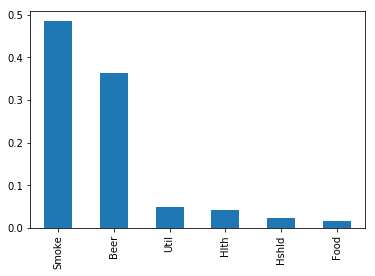

In [103]:
weights.sort_values(ascending=False).head(6).plot.bar()

In [106]:
ind_ew = erk.get_ind_returns(ew=True)
ind_cw = erk.get_ind_returns(ew=False)

In [112]:
sr = pd.DataFrame({'EW' : erk.sharpe_ratio(ind_ew, 0.03, 12),
                   'CW' : erk.sharpe_ratio(ind_cw, 0.03, 12)})

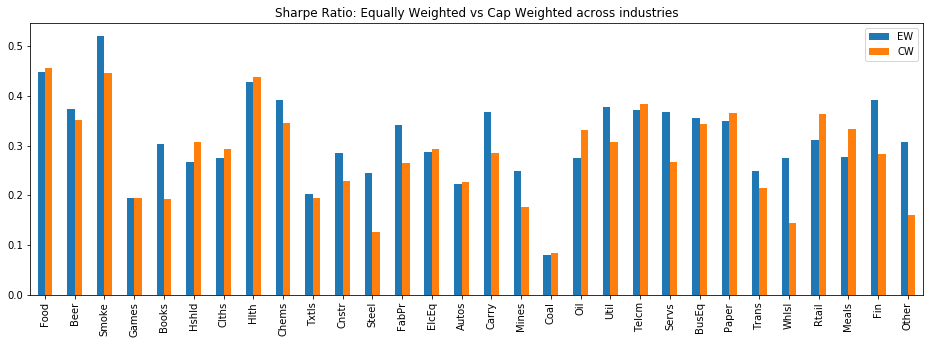

In [171]:
sr.plot.bar(figsize=(16,5), title='Sharpe Ratio: Equally Weighted vs Cap Weighted across industries')

In [114]:
(sr['EW'] > sr['CW']).sum()*100/sr.shape[0]

56.666666666666664

Text(0.5, 1.0, 'Average Trailing 5 year Sharpe Ratio across 30 Industry Portfolios 1945-2018')

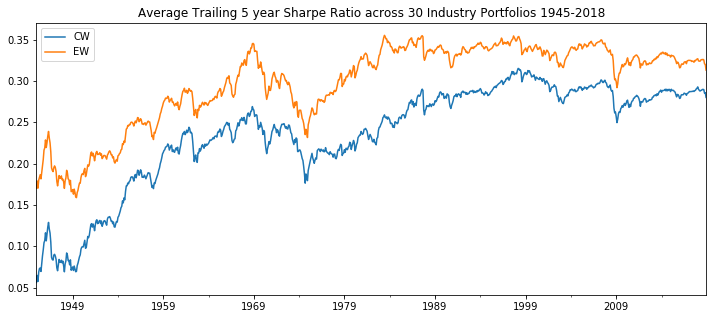

In [116]:
ax = ind_cw.rolling('1825D').apply(erk.sharpe_ratio, raw=True, kwargs={"riskfree_rate":0.03, "periods_per_year":12}).mean(axis=1)["1945":].plot(figsize=(12,5), label="CW", legend=True)
ind_ew.rolling('1825D').apply(erk.sharpe_ratio, raw=True, kwargs={"riskfree_rate":0.03, "periods_per_year":12}).mean(axis=1)["1945":].plot(ax=ax, label="EW", legend=True)
ax.set_title("Average Trailing 5 year Sharpe Ratio across 30 Industry Portfolios 1945-2018")

# Backtesting: EW vs CW


In [117]:
ind49_rets = erk.get_ind_returns(weighting="vw", n_inds=49)["1974":]
ind49_mcap = erk.get_ind_market_caps(49, weights=True)["1974":]

In [119]:
ind49_rets.head()

,Agric,Food,Soda,Beer,Smoke,Toys,Fun,Books,Hshld,Clths,...,Boxes,Trans,Whlsl,Rtail,Meals,Banks,Insur,RlEst,Fin,Other
1974-01,0.0229,0.0615,-0.0540,-0.0083,0.0301,0.0899,0.0858,-0.0101,-0.0260,0.0965,...,0.0050,0.0048,0.0552,0.0776,0.0144,0.0014,-0.0162,0.1311,0.0083,0.0102
1974-02,0.1382,0.0140,-0.0236,-0.0174,0.0185,-0.0257,-0.0032,-0.0528,-0.0342,0.0230,...,0.0156,0.0787,0.0239,0.0137,-0.0477,0.0165,-0.0219,-0.0249,0.0129,-0.0100
1974-03,-0.0157,-0.0156,-0.0406,-0.0220,-0.0600,0.0517,0.0361,0.0579,-0.0023,-0.0158,...,-0.0151,-0.0485,0.0159,-0.0452,0.0373,-0.0438,-0.0453,-0.0216,-0.0399,-0.0306
1974-04,-0.0926,-0.0265,-0.0415,-0.0366,-0.0277,-0.0749,-0.0796,-0.0646,-0.0419,-0.0477,...,-0.0269,-0.0393,-0.0194,-0.0206,-0.0296,-0.0510,-0.0919,-0.1227,-0.0684,-0.0535
1974-05,-0.0703,-0.0488,-0.0115,-0.0448,0.0559,0.0238,-0.0089,-0.0133,0.0102,-0.0691,...,-0.0130,-0.0469,-0.0390,0.0220,-0.0305,-0.1089,-0.0882,-0.1146,-0.0998,-0.0677


In [160]:
def weight_ew(r):
    
    n = len(r.columns)
    return pd.Series(1/n, index=r.columns)

def backtest_ws(r, estimation_window=60, weighting=weight_ew, **kwargs):
    n_periods = r.shape[0]
    windows = [(start, start+estimation_window) for start in range(n_periods-estimation_window+1)]
    
    weights = [weighting(r.iloc[win[0]:win[1]], **kwargs) for win in windows]
    weights = pd.DataFrame(weights, index=r.iloc[estimation_window-1:].index, columns=r.columns)
    returns = (weights * r).sum(axis="columns",  min_count=1) #mincount is to generate NAs if all inputs are NAs
    return returns
    

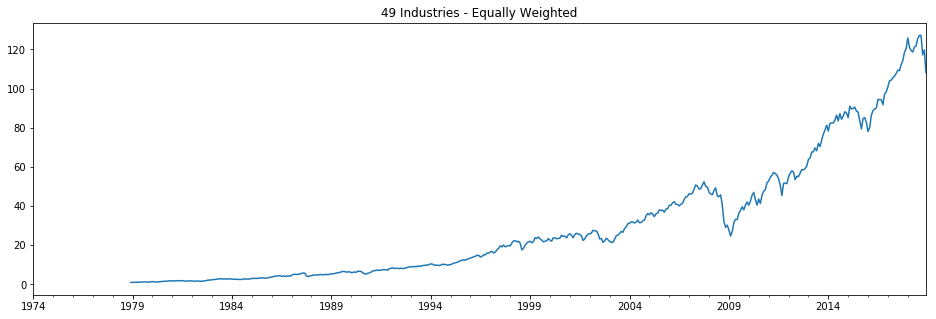

In [170]:
ewr = backtest_ws(ind49_rets, weighting=weight_ew)
ewi = (1+ewr).cumprod()
ewi.plot(figsize=(16,5), title="49 Industries - Equally Weighted");

In [164]:
def weight_cw(r, cap_weights, **kwargs):
    """
    Returns the weights of the CW portfolio based on the time series of capweights
    """
    return cap_weights.loc[r.index[0]]



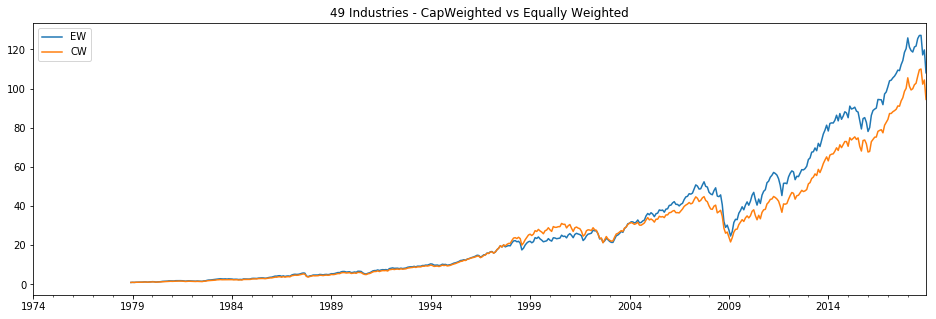

In [169]:
ewr = backtest_ws(ind49_rets)
cwr = backtest_ws(ind49_rets, weighting=weight_cw, cap_weights=ind49_mcap)
btr = pd.DataFrame({'EW': ewr,
                    'CW': cwr})
(1+btr).cumprod().plot(figsize=(16,5), title="49 Industries - CapWeighted vs Equally Weighted");

PeriodIndex(['1974-01', '1974-02', '1974-03', '1974-04', '1974-05', '1974-06',
             '1974-07', '1974-08', '1974-09', '1974-10',
             ...
             '2018-03', '2018-04', '2018-05', '2018-06', '2018-07', '2018-08',
             '2018-09', '2018-10', '2018-11', '2018-12'],
            dtype='period[M]', length=540, freq='M')

# Improving EW with CapWeight Tethering

Often in practice, we'll want to implement some sort of a modification of a pure strategy. For instance, although Equal Weight portfolios are popular, they'll be constrained in some way - for instance to match the sector weights of the cap-weighted benchmark or to make sure that microcap stocks are not overweighted. The motivation for doing so could be to make a portfolio more tradeable (e.g. some microcaps may not have the liquidity) or to improve the tracking error to the Cap-Weighted index.

As an illustration of how that can be achieved, we enhance our simple `weight_ew` allocator to (i) drop microcap stocks beyond a particular threshold, and (ii) impose a constraint that ensures that the maximum weight assigned to any stock is no more than some multiple of the weight it would be in a cap-weighted portfolio.


In [172]:
def weight_ew(r, cap_weights=None, max_cw_mult=None, microcap_threshold=None, **kwargs):
    
    n = len(r.columns)
    ew = pd.Series(1/n, index=r.columns)
    if cap_weights is not None:
        cw= cap_weights.loc[r.index[0]]
        if microcap_threshold is not None and microcap_threshold >0:
            microcap = cw < microcap_threshold
            ew[microcap] = 0
            ew = ew/ew.sum()
        if max_cw_mult is not None and max_cw_mult >0:
            ew = np.minimum(ew, max_cw_mult*cw)
            ew = ew/ew.sum()
    return ew
    

def backtest_ws(r, estimation_window=60, weighting=weight_ew, **kwargs):
    n_periods = r.shape[0]
    windows = [(start, start+estimation_window) for start in range(n_periods-estimation_window+1)]
    
    weights = [weighting(r.iloc[win[0]:win[1]], **kwargs) for win in windows]
    weights = pd.DataFrame(weights, index=r.iloc[estimation_window-1:].index, columns=r.columns)
    returns = (weights * r).sum(axis="columns",  min_count=1) #mincount is to generate NAs if all inputs are NAs
    return returns

def weight_cw(r, cap_weights, **kwargs):
    """
    Returns the weights of the CW portfolio based on the time series of capweights
    """
    w = cap_weights.loc[r.index[0]]
    return w/w.sum()


    

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
EW,0.123921,0.160660,-0.759092,6.659028,0.071404,0.102331,0.568799,-0.528292
EW-Tethered,0.125572,0.156923,-0.752967,6.187433,0.069778,0.099191,0.592597,-0.530654
CW,0.120165,0.147544,-0.717960,5.562648,0.065636,0.093769,0.594625,-0.515999


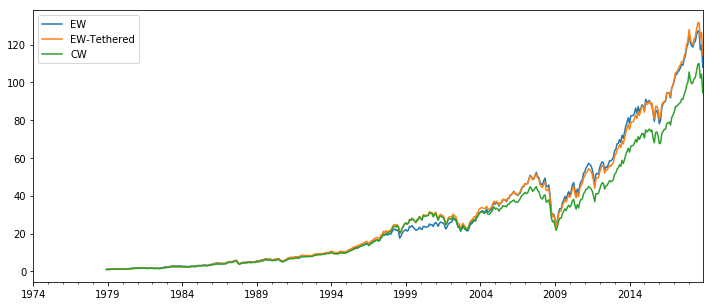

In [173]:
ewr = backtest_ws(ind49_rets)
ewtr = backtest_ws(ind49_rets, cap_weights=ind49_mcap, max_cw_mult=5, microcap_threshold=.005)
cwr = backtest_ws(ind49_rets, weighting=weight_cw, cap_weights=ind49_mcap)
btr = pd.DataFrame({"EW": ewr, "EW-Tethered": ewtr, "CW": cwr})
(1+btr).cumprod().plot(figsize=(12,5))
erk.summary_stats(btr.dropna())